In [1]:
from datetime import timedelta
from fuzzywuzzy import fuzz

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

import json
import os

/home/dottyz/miniconda3/envs/open-data/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
r = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
bikeshare_stations = json.loads(r.content)['data']['stations']
bikeshare_stations = pd.DataFrame(bikeshare_stations)[['station_id', 'name', 'lat', 'lon']].astype({
    'station_id': 'float64',
})

bikeshare_stations.to_csv('./data/bikeshare_stations.csv', index=False)

In [3]:
date_formats = {
    'Bikeshare Ridership (2017 Q1).csv': ['%d/%m/%Y %H:%M', -4],
    'Bikeshare Ridership (2017 Q2).csv': ['%d/%m/%Y %H:%M', -4],
    'Bikeshare Ridership (2017 Q3).csv': ['%m/%d/%Y %H:%M', 0],
    'Bikeshare Ridership (2017 Q4).csv': ['%m/%d/%y %H:%M:%S', 0],
}

df = pd.DataFrame()
for fn, fmt in date_formats.items():
    tmp = pd.read_csv(os.path.join('./data', fn))
    tmp['trip_start_time'] = pd.to_datetime(tmp['trip_start_time'], format=fmt[0], errors='coerce')
    tmp['trip_start_time'] = tmp['trip_start_time'] + timedelta(hours=fmt[1])

    df = pd.concat([df, tmp], sort=False).reset_index(drop=True)

In [4]:
stations_start = df[['from_station_id', 'from_station_name']]
stations_end = df[['to_station_id', 'to_station_name']]
stations_start.columns = stations_end.columns = ['station_id', 'name']

stations = pd.concat([stations_start, stations_end]).dropna(how='all').drop_duplicates().reset_index(drop=True)

no_ids = stations[stations['station_id'].isnull()]

In [5]:
for idx, miss in no_ids.iterrows():
    max_score = 0
    
    for i, exist in bikeshare_stations[['station_id', 'name']].iterrows():
        score = fuzz.ratio(miss['name'], exist['name'])
        
        if score > 80 and score > max_score:
            max_score = score
            no_ids.at[idx, 'station_id'] = exist['station_id']
    
    if max_score <= 80:
        print('WARN: {0} station could not be matched to an existing station'.format(miss['name']))

no_ids = no_ids.dropna()

WARN: Michael Sweet Ave / St. Patrick St station could not be matched to an existing station
WARN: Bremner Blvd / Spadina Ave station could not be matched to an existing station
WARN: Bay St / Bloor St W station could not be matched to an existing station
WARN: Bathurst St / Queens Quay W station could not be matched to an existing station
WARN: Wellesley St / Queen's Park Cres station could not be matched to an existing station
WARN: Davenport Rd / Bedford Rd station could not be matched to an existing station
WARN: Victoria St / Gould St (Ryerson University) station could not be matched to an existing station
WARN: Woodbine Subway Green P (Cedarvale Ave) station could not be matched to an existing station
WARN: Stephenson Ave / Main St station could not be matched to an existing station
WARN: Roxton Rd / College St station could not be matched to an existing station
WARN: Base Station station could not be matched to an existing station
WARN: Fringe Next Stage - 7219 station could not

In [6]:
stations = pd.concat([stations[~stations['station_id'].isnull()], no_ids])\
             .merge(bikeshare_stations[['station_id', 'lat', 'lon']], how='left', on='station_id')\
             .drop_duplicates()

In [7]:
df = df.merge(stations, how='inner', left_on='from_station_name', right_on='name') \
       .merge(stations, how='inner', left_on='to_station_name', right_on='name', suffixes=['_from', '_to']) \
       .drop_duplicates()

df = df[[x for x in df.columns if not x.endswith('_station_id') and not x.endswith('_station_name') and x != 'trip_stop_time']]

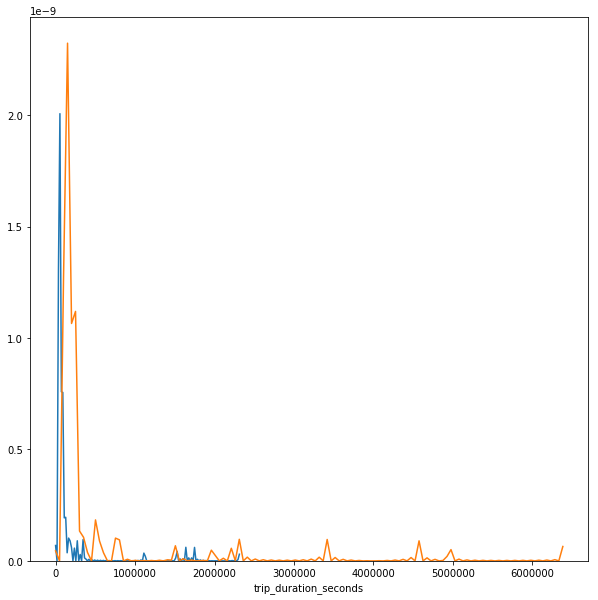

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for user in df['user_type'].unique():
    sns.distplot(df[df['user_type']==user]['trip_duration_seconds'], hist=False, ax=ax)

plt.savefig('./visualization/raw_distributions.png')

In [9]:
df.shape

(1463724, 12)

In [10]:
df = df[(df['trip_duration_seconds']>=60)]

In [11]:
df.describe()

,trip_id,trip_duration_seconds,station_id_from,lat_from,lon_from,station_id_to,lat_to,lon_to
count,1.433950e+06,1.433950e+06,1.433950e+06,1.426982e+06,1.426982e+06,1.433950e+06,1.427302e+06,1.427302e+06
mean,1.544960e+06,1.041265e+03,7.094193e+03,4.365376e+01,-7.939064e+01,7.093312e+03,4.365293e+01,-7.939006e+01
std,4.792596e+05,9.962779e+03,7.632587e+01,1.065283e-02,2.013269e-02,7.607456e+01,1.029167e-02,2.028006e-02
min,7.123820e+05,6.000000e+01,7.000000e+03,4.362671e+01,-7.947657e+01,7.000000e+03,4.362671e+01,-7.947657e+01
25%,1.130734e+06,4.280000e+02,7.032000e+03,4.364561e+01,-7.940146e+01,7.033000e+03,4.364561e+01,-7.939960e+01
50%,1.545970e+06,6.660000e+02,7.068000e+03,4.365282e+01,-7.938758e+01,7.067000e+03,4.365212e+01,-7.938750e+01
75%,1.957823e+06,1.032000e+03,7.158000e+03,4.366197e+01,-7.937990e+01,7.158000e+03,4.366036e+01,-7.937988e+01
max,2.383646e+06,6.382030e+06,7.289000e+03,4.369402e+01,-7.928898e+01,7.289000e+03,4.369402e+01,-7.928898e+01


In [12]:
df.shape

(1433950, 12)

In [12]:
q1 = df['trip_duration_seconds'].quantile(0.25)
q3 = df['trip_duration_seconds'].quantile(0.75)
interquartile_range = q3 - q1

df = df[~((df['trip_duration_seconds'] < (q1 - 1.5 * interquartile_range))|(df['trip_duration_seconds'] > (q3 + 1.5 * interquartile_range)))].reset_index(drop=True)

In [13]:
df.shape

(1351116, 12)

In [14]:
df.to_csv('./data/bikeshare_ridership.csv', index=False)